# How to get a 100% Guaranteed Valid Tool Call response

## 1. Install Litelines

In [1]:
%pip install --quiet --upgrade litelines

## 2. Download a model and its tokenizer

In [2]:
# Use cuda for faster inference
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
assert device == torch.device("cuda"), "In the Runtime tab, please Change runtime type to GPU"

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)
model = AutoModelForCausalLM.from_pretrained(MODEL_ID).to(device)

## 3. Define a Pydantic schema describing the tool

In [4]:
from typing import Literal
from pydantic import BaseModel, Field

class Multiply(BaseModel):
    """Multiply two integers together."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")

## 4. Prepare the inputs to the LLM

In [5]:
from openai import pydantic_function_tool

user_input = "What's 24 times 42?"
messages = [{"role": "user", "content": user_input}]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tools=[pydantic_function_tool(Multiply)],
    return_tensors="pt",
    return_dict=True,
).to(device)

## 5. Define the processor and visualize it

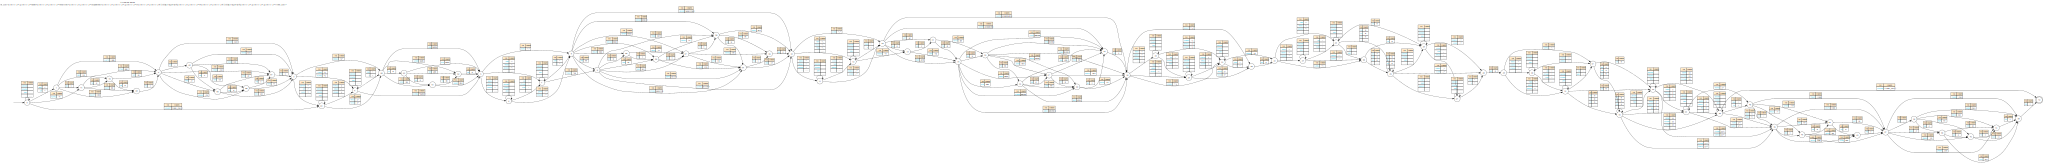

In [6]:
from litelines.transformers import SchemaProcessor

processor = SchemaProcessor(
    response_format=Multiply,
    tokenizer=tokenizer,
    include_tool_call=True
)
processor.show_graph()

## 6. Generate a structured response

In [7]:
generated = model.generate(**inputs, logits_processor=[processor], temperature=0.1, max_new_tokens=100)
print(f"Response:\n{tokenizer.decode(generated[0][inputs['input_ids'].shape[-1]:-1])}")

Response:
<tool_call>
{"name": "Multiply", "arguments": {"a": 24, "b": 42}}
</tool_call>


## 7. Visualize the selected path

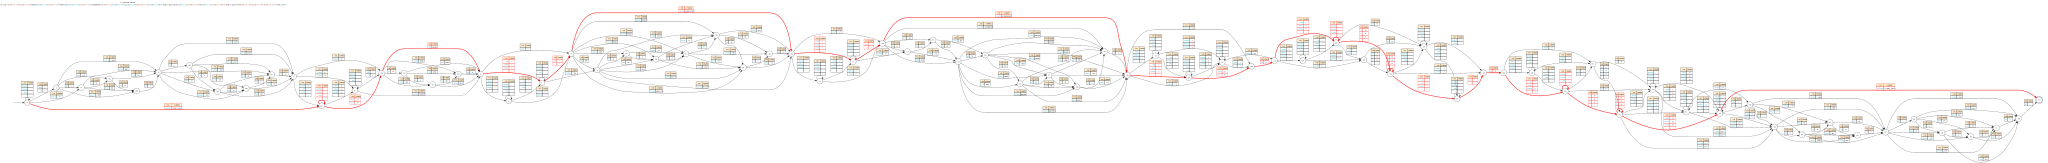

In [8]:
processor.show_graph()